# <span style="color:teal">Plant </span><span style="color:green">*Seedlings*</span><span style="color:teal"> Classification</span>
***



#### Initialization

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


#### Load Data

In [2]:
train_dir = '../input/plant-seedlings-classification/train'
test_dir = '../input/plant-seedlings-classification/test'
sample_submission = pd.read_csv('../input/plant-seedlings-classification/sample_submission.csv')


#### Different Species

In [3]:
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
              'Small-flowered Cranesbill', 'Sugar beet']

for species in SPECIES:
    print('{} {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))
    

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


#### Training Data Files

In [4]:
train = []

for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append(['../input/plant-seedlings-classification/train/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)


Training Data:  (4750, 3)


#### Image Pre-processing

In [5]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp


#### Loading Traing Data

In [6]:
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)


CPU times: user 54.4 s, sys: 3.54 s, total: 57.9 s
Wall time: 1min 17s


#### Sample Images

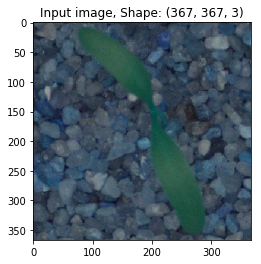

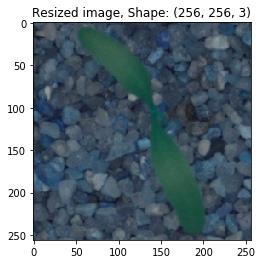

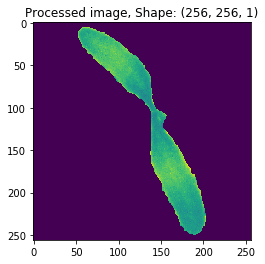

In [7]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(256,256)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()


#### One-hot Encoding

In [8]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))


#### CV-Partition

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10)


#### Input Shape

In [10]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)


Input Shape is : (256, 256, 4)


## <span style="color:teal">Architecture</span>
---

In [11]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Dropout, Flatten, Dense

In [12]:
model = Sequential()

input_shape = (256, 256, 4)

model.add(Conv2D(filters=64, kernel_size=1, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))

model.add(Dense(12, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 128)       0         
__________

#### Compile the model

In [13]:
model.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])


#### Set a learning rate annealer

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)


#### Data Augumentation

In [15]:
datagen = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)


In [16]:
batch_size = 32
epochs = 40


#### Load the Saved Weights *(pre-trained) *

In [17]:
model.load_weights('../input/cnn-model/cnn_model.h5')

In [18]:
# Training
#history = model_new.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = epochs,
                                  #validation_data = (x_val,y_val), verbose = 1, 
                                  #steps_per_epoch=x_train.shape[0] // batch_size, 
                                  #callbacks=[learning_rate_reduction])

### <span style="color:teal">Predictions</span>
***

In [19]:
%%time

test = []
for file in os.listdir(os.path.join(test_dir)):
    test.append(['../input/plant-seedlings-classification/test/{}'.format(file)])

test = pd.DataFrame(test, columns=['file'])
print(test.head(5))


x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_test = np.array(x_test)


                                                file
0  ../input/plant-seedlings-classification/test/1...
1  ../input/plant-seedlings-classification/test/7...
2  ../input/plant-seedlings-classification/test/2...
3  ../input/plant-seedlings-classification/test/9...
4  ../input/plant-seedlings-classification/test/c...
CPU times: user 5.78 s, sys: 491 ms, total: 6.27 s
Wall time: 8.63 s


#### Sample Test images

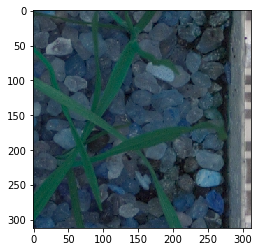

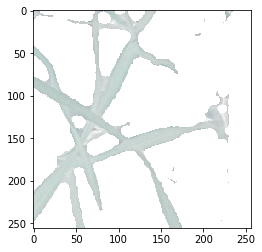

In [20]:
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

img_processed = x_test[randm]
plt.imshow(img_processed)
plt.show()


#### Prediction Score [Validation Set]

In [21]:
score = model.evaluate(x_val,y_val)
print('Accuracy on Validation Set',score[1])

475/475 [==============================] - 7s 14ms/step
Accuracy on Validation Set 0.9536842096479315


#### Prediction on Test Set

In [22]:
Pred_labels = np.argmax(model.predict(x_test),axis = 1)


#### Submit Test results (Deep Neural Network with _New Model_)

In [23]:
Pred_labels = pd.DataFrame(Pred_labels,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 

submission.to_csv('submission.csv', index=False)
print(submission.head())


            file                    species
0  0021e90e4.png  Small-flowered Cranesbill
1  003d61042.png                    Fat Hen
2  007b3da8b.png                 Sugar beet
3  0086a6340.png           Common Chickweed
4  00c47e980.png                 Sugar beet


***
## <span style="color:teal">Applying Suppot Vector Machine</span>
***

#### Extracting Features from last Layer

In [24]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)


(4275, 100)
(475, 100)
(794, 100)


### Applying SVM wihtout any hyperparameter tuning

In [25]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


#### Prediction Score [Training Features]

In [26]:
svm.score(feat_train,np.argmax(y_train,axis=1))

0.9988304093567252

#### Prediction Score [Validation Features]

In [27]:
svm.score(feat_val,np.argmax(y_val,axis=1))

0.5789473684210527

In [28]:
Pred_labels = svm.predict(feat_val)

In [29]:
from sklearn.metrics import classification_report

In [30]:
feat_val.shape

(475, 100)

In [31]:
Pred_labels.shape

(475,)

#### Confusion matrix for our validation set

In [32]:
print(classification_report(np.argmax(y_val,axis=1), Pred_labels)) 

             precision    recall  f1-score   support

          0       1.00      0.32      0.49        28
          1       1.00      0.70      0.82        40
          2       1.00      0.23      0.37        31
          3       0.98      0.66      0.79        64
          4       0.88      0.35      0.50        20
          5       1.00      0.44      0.62        45
          6       0.24      1.00      0.39        62
          7       1.00      0.21      0.34        24
          8       0.94      0.48      0.63        63
          9       0.75      0.40      0.52        15
         10       1.00      0.70      0.82        46
         11       1.00      0.73      0.84        37

avg / total       0.88      0.58      0.62       475



### Applying SVM with hyperparameter tuning

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm, metrics, datasets

In [34]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(feat_train,np.argmax(y_train,axis=1))

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
clf.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

#### Prediction Score [Training Features]

In [36]:
clf.score(feat_train,np.argmax(y_train,axis=1))


0.9976608187134502

#### Prediction Score [Validation Features]

In [37]:
clf.score(feat_val,np.argmax(y_val,axis=1))


0.9536842105263158

In [38]:
Pred_labels = clf.predict(feat_val)

#### Confusion matrix for our validation set

In [39]:
print(classification_report(np.argmax(y_val,axis=1), Pred_labels)) 

             precision    recall  f1-score   support

          0       0.84      0.75      0.79        28
          1       1.00      0.95      0.97        40
          2       0.97      1.00      0.98        31
          3       0.97      1.00      0.98        64
          4       0.95      0.95      0.95        20
          5       0.96      1.00      0.98        45
          6       0.89      0.95      0.92        62
          7       1.00      0.92      0.96        24
          8       0.98      0.94      0.96        63
          9       0.81      0.87      0.84        15
         10       0.98      1.00      0.99        46
         11       1.00      0.97      0.99        37

avg / total       0.95      0.95      0.95       475



#### Predict on [Test Features]

In [40]:
Pred_labels_svm = clf.predict(feat_test)


#### Submission

In [41]:
Pred_labels = pd.DataFrame(Pred_labels_svm,index =None,columns=['species_num'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right = test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 
print(submission.head())

submission.to_csv('submission_svm.csv', index=False)

            file                    species
0  0021e90e4.png  Small-flowered Cranesbill
1  003d61042.png                    Fat Hen
2  007b3da8b.png                 Sugar beet
3  0086a6340.png           Common Chickweed
4  00c47e980.png                 Sugar beet


***
## <span style="color:teal">Applying Random Forest</span>
***

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV

In [43]:
rf = RandomForestClassifier(n_jobs=-1)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 3)
CV_rf.fit(feat_train,np.argmax(y_train,axis=1))
CV_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500}

#### Prediction Accuracy [Training Set]

In [44]:
#Prediction Score[Training Set]
print('Prediction Score for Training Set' + str(CV_rf.score(feat_train,np.argmax(y_train,axis=1))))

Prediction Score for Training Set0.9829239766081871


#### Prediction Score [Validation Test]

In [45]:
#PS on [Validation Set]
print('Prediction Score for Validation Set'+ str(CV_rf.score(feat_val,np.argmax(y_val,axis=1))))

Prediction Score for Validation Set0.9389473684210526


#### Predict on test

In [46]:
#Prediction on [Test] for competition
Pred_labels_RF = CV_rf.predict(feat_test)

#### Submission

In [47]:
Pred_labels = pd.DataFrame(Pred_labels_RF,index =None,columns=['species_num'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right = test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 
print(submission.head())

submission.to_csv('submission_RF.csv', index=False)

            file                    species
0  0021e90e4.png  Small-flowered Cranesbill
1  003d61042.png                    Fat Hen
2  007b3da8b.png                 Sugar beet
3  0086a6340.png           Common Chickweed
4  00c47e980.png                 Sugar beet


***
## <span style="color:teal">Predict on Smaller dataset (Images extracted from google) using RF and SVM</span>
***

#### Load Data

In [48]:
small_test_dir = '../input/test-new/Test_new'

#### Cleaning our smaller dataset

In [49]:
%%time

test = []
for file in os.listdir(os.path.join(small_test_dir)):
    test.append(['../input/test-new/Test_new/{}'.format(file)])

test = pd.DataFrame(test, columns=['file'])
print(test.head(5))


small_x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    small_x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

small_x_test = np.array(small_x_test)

                                       file
0        ../input/test-new/Test_new/789.jpg
1  ../input/test-new/Test_new/2c28f05a9.png
2     ../input/test-new/Test_new/131415.jpg
3  ../input/test-new/Test_new/3c75e7d79.png
4  ../input/test-new/Test_new/505152jpg.jpg
CPU times: user 366 ms, sys: 15.1 ms, total: 381 ms
Wall time: 468 ms


#### Use fully connected layer of CNN

In [50]:
small_feat_test = model_feat.predict(small_x_test)
print(small_feat_test.shape)

(20, 100)


#### Using RF

In [51]:
Pred_labels_small_RF = CV_rf.predict(small_feat_test)

#### Using SVM

In [52]:
Pred_labels_small_SVM = clf.predict(small_feat_test)

#### Submission for Small SVM

In [53]:
Pred_labels = pd.DataFrame(Pred_labels_small_SVM,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(small_test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 

submission.to_csv('submission_small_svm.csv', index=False)
print(submission.head())

            file                    species
0  0ebf8f2f4.png                      Maize
1  1694a70e4.png          Scentless Mayweed
2  1b490196c.png            Shepherds Purse
3  5bc6595f6.png                      Maize
4  60f0bc617.png  Small-flowered Cranesbill


#### Submission for Small RF

In [54]:
Pred_labels = pd.DataFrame(Pred_labels_small_RF,index =None,columns=['species_num'])

test_id = []
for file in os.listdir(small_test_dir):
    test_id.append(['{}'.format(file)])

test_id = pd.DataFrame(test_id, columns=['file'])

test_df = pd.DataFrame()
test_df['species_num'] = Pred_labels['species_num']
test_df['file'] = test_id['file']
test_df['species'] = [SPECIES[i] for i in Pred_labels['species_num']]

submission = pd.merge(left=sample_submission, right=test_df[['file', 'species']], on="file", how="right")
submission.drop(['species_x'], axis = 1, inplace = True)
submission.columns = ['file','species'] 

submission.to_csv('submission_small_RF.csv', index=False)
print(submission.head())

            file                    species
0  0ebf8f2f4.png                      Maize
1  1694a70e4.png          Scentless Mayweed
2  1b490196c.png            Shepherds Purse
3  5bc6595f6.png                      Maize
4  60f0bc617.png  Small-flowered Cranesbill
